This notebook is for the purpose of converting the essays in string form to word embedding vectorized form. This notebook makes use of the GLoVe word embeddings. More information about these word embeddings can be found here: https://nlp.stanford.edu/projects/glove/

If you would like to follow along with the preprocessing work, follow the link above and download the glove.6B.zip file to the "data/" directory of this project. Then uncompress the zip file to reveal directory named "glove.6B/" with 4 txt files inside. These are the four available word embeddings. You are now able to proceed with this notebook. 

In [1]:
from src.preprocess import get_data, vectorize_essays, pad_embedding, word_count
%load_ext autoreload
%autoreload 2

In [2]:
# Import training data from tsv file and store in a pandas dataframe
data_path = './data/training_set_rel3.tsv'
essay_df = get_data(data_path)

We can inspect the contents of the dataframe to understand what information is provided in the training set.

More EDA if we have time

We'd like to drop some columns that are irrelevant to the neural network

In [3]:
drop_labels =['rater1_trait1', 'rater1_trait2', 'rater1_trait3', 'rater1_trait4', 'rater1_trait5', 'rater1_trait6',\
              'rater2_trait1', 'rater2_trait2', 'rater2_trait3', 'rater2_trait4', 'rater2_trait5', 'rater2_trait6',\
              'rater3_trait1', 'rater3_trait2', 'rater3_trait3', 'rater3_trait4', 'rater3_trait5', 'rater3_trait6',\
              'rater3_domain1', 'rater1_domain2', 'rater2_domain2', 'domain2_score']
essay_df.drop(columns=drop_labels, inplace=True)
essay_df.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",4,4,8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5,4,9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4,3,7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5,5,10
4,5,1,"Dear @LOCATION1, I know having computers has a...",4,4,8


The given dataset holds essays from 8 distinct "essay sets". In order to speed training time and reduce memory impact, we will only examine a subset of these essay sets. The rest of the essays can be discarded. For a more detailed analysis of why certain essay sets were used and some were not, please see the research report. 

In [4]:
sets = [1,3,4,5,6]
essay_df = essay_df[essay_df['essay_set'].isin(sets)]

"Examining essays in sets {}".format(essay_df.essay_set.unique())

'Examining essays in sets [1 3 4 5 6]'

In [5]:
essays = essay_df['essay'] # A list of essays as strings
embed_size = 200 # Desired word embedding size. Chosen from the options: [50, 100, 200, 300]

# Add a column to dataframe with essays as word embeddings
essay_df['essays_embed'] = vectorize_essays(essays, embed_size=embed_size, verbose=False)

Vectorizing essays...
8884 Total Essays Vectorized!


Next we will partition the dataset into a larger dataset for training and validation, and
a smaller dataset for testing.

In [6]:
test_prop = 0.2
test_df = essay_df.sample(frac=test_prop,random_state=33)
train_df = essay_df.drop(test_df.index)

print('The train dataset has {} essays.'.format(len(train_df)))
print('The test dataset has {} essays.'.format(len(test_df)))
print('Saving the test dataset...')
test_df.to_pickle('./data/test_df.pkl')
print('Test dataset saved!')

The train dataset has 7107 essays.
The test dataset has 1777 essays.
Saving the test dataset...
Test dataset saved!


We would also like to remove some outliers for word count. The chosen method is to examine each essay set individually due to large variations of lenghts between essay sets. For each essay set, remove essays that have word counts larger than 1 standard deviation greater than the mean.

In [7]:
train_df['word_count'] = train_df.apply(lambda row: word_count(row), axis=1)
test_df['word_count'] = test_df.apply(lambda row: word_count(row), axis=1)

# This would be a good place to put a visualization of word count statistics for each set
# Both before and after the modification

wc_stats = {}
for set in sets:
    mean,std = train_df[train_df['essay_set']==set]['word_count'].agg(['mean','std'])
    
    # Record the min and max allowable word counts for each set
    wc_stats[set] = (int(round(mean-std)),int(round(mean+std)))

In [8]:
for set in sets:
    wc_min, wc_max = wc_stats[set]
    train_df = train_df[(train_df['essay_set']!=set) | (train_df['word_count']<wc_max)]
    print('The maximum essay length from set {} is {} words'.format(set, wc_max))

The maximum essay length from set 1 is 426 words
The maximum essay length from set 3 is 137 words
The maximum essay length from set 4 is 120 words
The maximum essay length from set 5 is 153 words
The maximum essay length from set 6 is 175 words


Next we will pad each essay to the maximum length of the essay set so that all essays from an essay set have a uniform size of word embedding matrix. This will allow for the essay embedding matrix to be input to the Neural Network. 

In [9]:
train_df['essays_embed'] = train_df.apply(lambda x: pad_embedding(x['essays_embed'], x['essay_set'], wc_stats, right_pad=True), axis=1)
for set in sets:
    n_essays = len(train_df[train_df['essay_set']==set])
    shapes = [train_df[train_df['essay_set']==set]['essays_embed'].iloc[x].shape for x in range(n_essays)]
    if all(shape==shapes[0] for shape in shapes):
        print('All {} padded essays in set {} have a shape of {}'.format(n_essays, set, shapes[0]))
    else:
        print('Essay shapes in set {} do not match. Please ensure that essays were correctly padded.'.format(set))

All 1196 padded essays in set 1 have a shape of (426, 200)
All 1120 padded essays in set 3 have a shape of (137, 200)
All 1218 padded essays in set 4 have a shape of (120, 200)
All 1212 padded essays in set 5 have a shape of (153, 200)
All 1226 padded essays in set 6 have a shape of (175, 200)


Next we would like to normalize the scores for each set to a consistent scale.

In [10]:
# Add min and max score for each set to the dataframe
score_ranges = [(0,0), (2,12), (0,0), (0,3), (0,4), (0,4), (0,4)]

for idx in train_df.index:
    train_df.loc[idx,'min_score']=score_ranges[train_df.loc[idx,'essay_set']][0]
    train_df.loc[idx,'max_score']=score_ranges[train_df.loc[idx,'essay_set']][1]

In [11]:
max_score = max([b for a,b in score_ranges])
for idx in train_df.index:
    train_df.loc[idx,'norm_score']=train_df.loc[idx,'domain1_score']*max_score/train_df.loc[idx,'max_score']
train_df['norm_score']=[int(x) for x in train_df['norm_score']]

In [12]:
# We no longer need the raw text from each essay
drop_labels =['essay']
train_df.drop(columns=drop_labels, inplace=True)
train_df.head()

,essay_id,essay_set,rater1_domain1,rater2_domain1,domain1_score,essays_embed,word_count,min_score,max_score,norm_score
0,1,1,4,4,8,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",299,2.0,12.0,8
1,2,1,5,4,9,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",349,2.0,12.0,9
2,3,1,4,3,7,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",236,2.0,12.0,7
4,5,1,4,4,8,"[[0.1285, 0.68849, 0.83504, -0.16483, -0.36831...",387,2.0,12.0,8
9,10,1,5,4,9,"[[0.15637, -0.40361, -0.29629, -0.34259, -0.18...",419,2.0,12.0,9


In [13]:
# Store the preprocessed data frame for later use
train_df.to_pickle('./data/train_df.pkl')

# Data vision exploratory

In [14]:
#Dependencies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

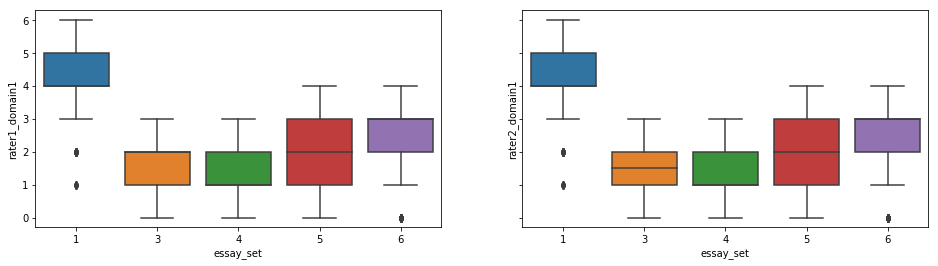

In [15]:
#Distibution of the scores for rater1 and rater2 in the train set
fig,ax = plt.subplots(1,2,figsize=(16,4),sharey=True)
_ = sns.boxplot(x='essay_set',y='rater1_domain1',data=train_df,ax=ax[0])
_ = sns.boxplot(x='essay_set',y='rater2_domain1',data=train_df,ax=ax[1])

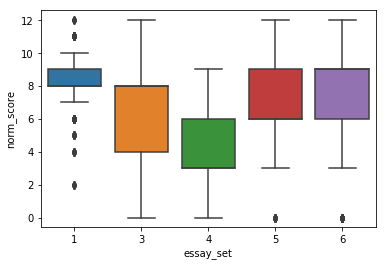

In [19]:
#Distribution of the final score (sum of both)
_ = sns.boxplot(x='essay_set', y='norm_score', data = train_df)

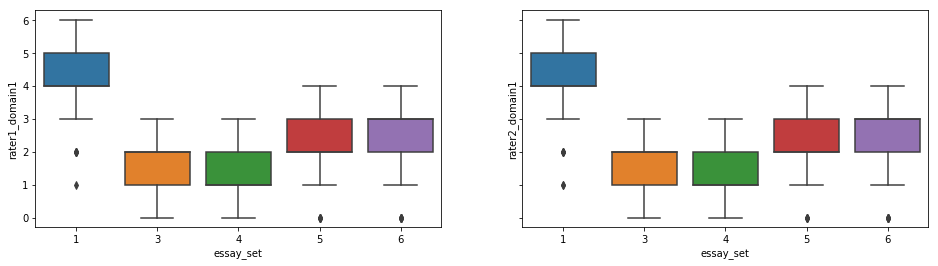

In [16]:
#Distibution of the scores for rater1 and rater2 in the test set
fig,ax = plt.subplots(1,2,figsize=(16,4),sharey=True)
_ = sns.boxplot(x='essay_set',y='rater1_domain1',data=test_df,ax=ax[0])
_ = sns.boxplot(x='essay_set',y='rater2_domain1',data=test_df,ax=ax[1])

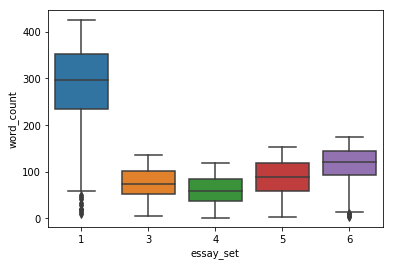

In [17]:
#Distribution of word count in the train set
_ = sns.boxplot(x='essay_set', y='word_count', data=train_df)

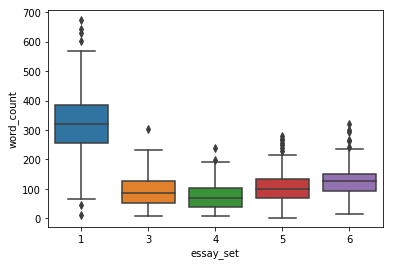

In [18]:
#Distribution of word count in the test set
_ = sns.boxplot(x='essay_set', y='word_count', data=test_df)